# Face Recognize Extract and preprocess Face in the image



In [1]:
from google.colab import drive # Connect with my drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mtcnn # mtnn is pre-train model to Extract Face in your photo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.9 MB/s eta 0:00:00


In [3]:

# import libraries

import cv2 as cv
import os
import numpy as np
from IPython.display import display
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # Set the logging level to filter out INFO and WARNING messages



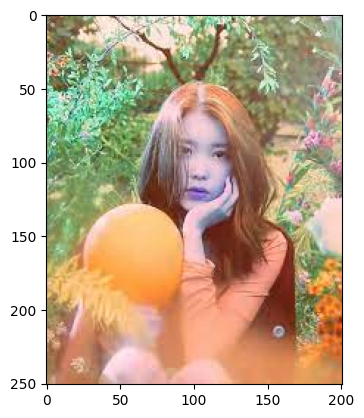

In [4]:
from google.colab.patches import cv2_imshow # Mybe, cv2.imshow get struck in gooogle colab
img = cv.imread("/content/drive/MyDrive/FaceRecognize/data/IU/iu1.jpg")
# Defaulting, OpenCv BGR channel format and plt can reads images as RGB channel format
plt.imshow(img) # BGR


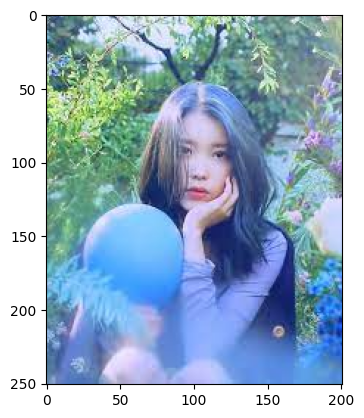

In [5]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

## Use MTCNN to Etract Face of image

In [6]:
# USE MTCNN to Feature-Extract FACE IN THE IMAGE
from mtcnn.mtcnn import MTCNN

detector = MTCNN() # initial MTCNN object
results = detector.detect_faces(img)



1/1 [==============================] - 0s 253ms/step


In [7]:
results
# MTCNN will return 1 list of distrionary
# this here i want get start, end-point of image to draw bounding

[{'box': [80, 68, 48, 66],
  'confidence': 0.9986355900764465,
  'keypoints': {'left_eye': (94, 93),
   'right_eye': (118, 95),
   'nose': (103, 108),
   'mouth_left': (94, 119),
   'mouth_right': (111, 122)}}]

In [8]:
x, y, w, h = results[0]['box']

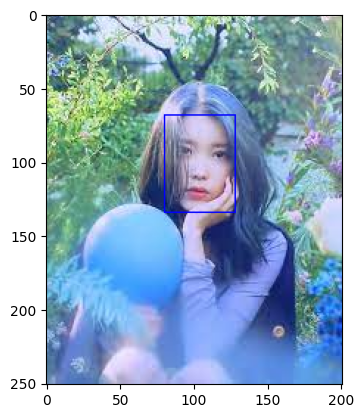

In [9]:
img = cv.rectangle(img, (x, y), (x+w, y+h), (0,0,255, 10))
plt.imshow(img)

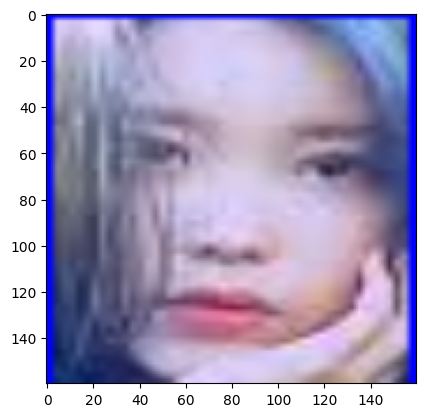

In [10]:
my_face = img[y:y+h, x:x+w+1]
# FaceNet takes as input 160x160 so i want to resize this my face
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

In [11]:
my_face

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  7,   7, 255],
        ...,
        [  4,   5, 253],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [ 31,  30, 255],
        ...,
        [ 16,  21, 246],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  5,  14, 216],
        ...,
        [ 12,  12, 209],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  3,  12, 215],
        ...,
        [ 10,  10, 208],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  2,  12, 214],
        ...,
        [ 10,  10, 207],
        [  0,   0, 255],
        [  0,   0, 255]]



## Automating Face Extraction
- taking that image
- changing Channel
- take it to MTCNN model
- resizing it

***-> Let't get do it***

In [12]:

class FACELOADING:
    def __init__(self, directory):
      # declare Attribute of class
      self.directory = directory
      self.size = (160, 160)
      self.X = []
      self.Y = []
      self.detector = MTCNN()

    def Extract_face(self, filename):
      img = cv.imread(filename)
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
      x, y, w, h = self.detector.detect_faces(img)[0]['box']
      x, y = abs(x), abs(y)
      face = img[y:y+h, x:x+w]
      face = cv.resize(face, self.size)
      return face


    def load_faces(self, dir):
        Face = []
        for im_name in os.listdir(dir):
          # use try catch if in directory have invalid format
            try:
                path = dir + im_name
                single_face = self.Extract_face(path)
                Face.append(single_face)

            except Exception as e:
                pass

        return Face


    def loaded_class(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory + "/" + sub_dir + "/"
            FACES = self.load_faces(path)
            label = [sub_dir for _ in range(len(FACES))]
            self.X.extend(FACES)
            self.Y.extend(label)
        return np.asarray(self.X), np.asarray(self.Y)

    def plot_img(self):
        plt.figure(figsize = (18,12))
        for num, image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows, ncols, num+1)
            plt.imshow(image)
            plt.axis("off")







In [15]:
faceloading = FACELOADING("/content/drive/MyDrive/FaceRecognize/data")
X, Y = faceloading.loaded_class()


1/1 [==============================] - 0s 17ms/step


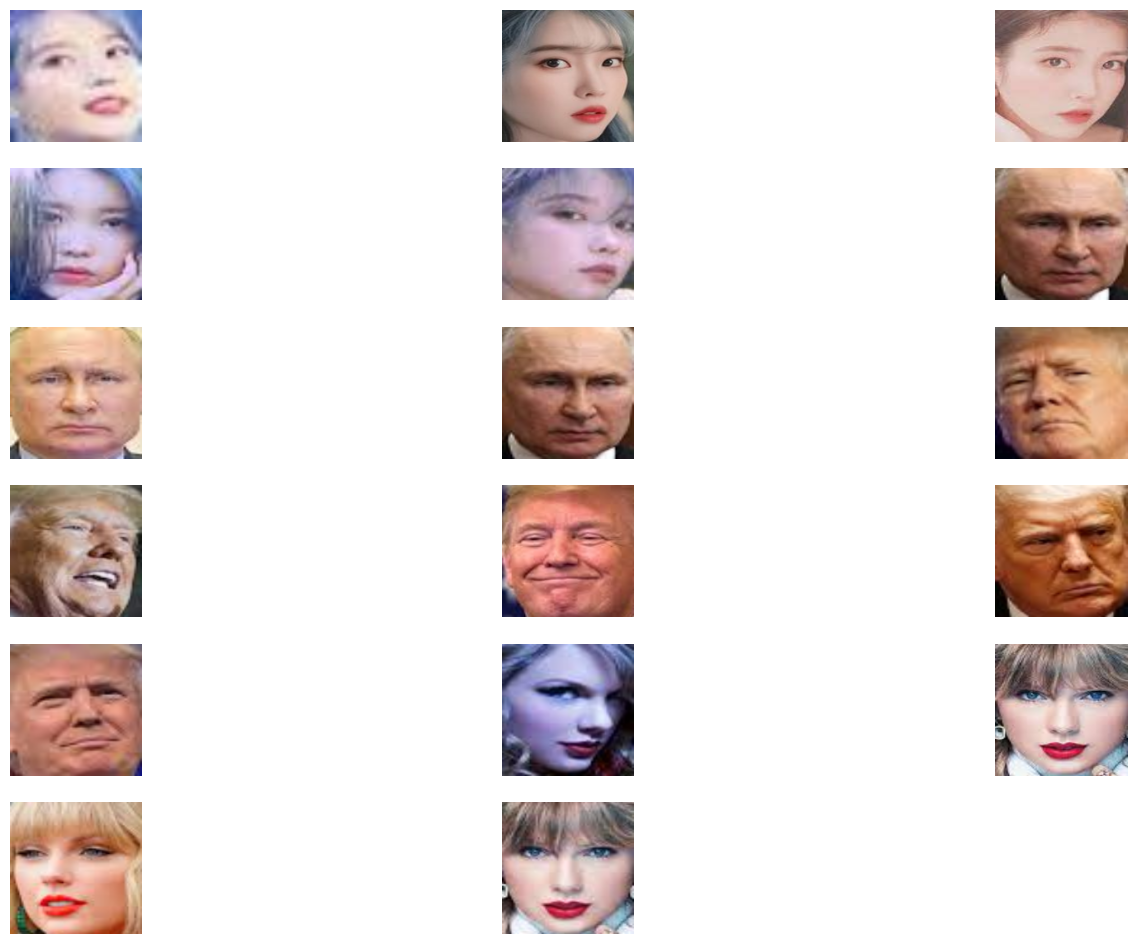

In [16]:
faceloading.plot_img()


## FaceNet Part

In [17]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=65cf5d5eb61ee049e32d1963ec00b4984f0128d6c47e8da83e632edc31b0881e
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [18]:
from keras_facenet import FaceNet

embedder = FaceNet()


def get_embedding(face_img):
    face_omg = face_img.astype('float32') #3D dimention (160,160,3)
    face_img = np.expand_dims(face_img, axis = 0)

    #4 (NONEX160X160X3)
    yhat = embedder.embeddings(face_img)
    return yhat[0]


In [19]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)


1/1 [==============================] - 0s 93ms/step


In [20]:
np.savez_compressed('Face_Embedding_done_4_classes.npz', EMBEDDED_X, Y)

In [21]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

## SVM model


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(EMBEDDED_X, Y, shuffle = True, random_state = 42)

In [23]:
from sklearn.svm import SVC

model = SVC(kernel= 'linear', probability = True)
model.fit(X_train, y_train)


SVC(kernel='linear', probability=True)

In [24]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [25]:
from sklearn.metrics import  accuracy_score

accuracy_score(y_train, ypreds_train)

1.0

In [26]:
accuracy_score(y_test, ypreds_test)

1.0

In [27]:
t_im = cv.imread("/content/drive/MyDrive/FaceRecognize/data/IU/iu3.jpg")

In [28]:
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x, y, w, h = detector.detect_faces(t_im)[0]['box']

1/1 [==============================] - 0s 36ms/step


In [29]:
t_im = t_im[y:y+h, x: x+w]
t_im = cv.resize(t_im, (160, 160))
test_im = get_embedding(t_im)

1/1 [==============================] - 0s 66ms/step


In [30]:
test_im.shape

(512,)

In [31]:
test_im = [test_im]
test_im

[array([ 5.38150333e-02, -7.99791422e-03,  2.68554799e-02,  2.74883155e-02,
        -2.66147722e-02, -6.09507039e-03, -3.35588939e-02,  4.63951118e-02,
         4.35908325e-02,  1.98797062e-02,  1.34848803e-01, -1.23625656e-03,
         1.17290176e-01,  7.09273070e-02,  2.96727438e-02, -8.74008685e-02,
        -1.03640342e-02, -2.06578639e-04, -2.06834525e-02,  3.70978154e-02,
        -4.15459163e-02, -2.57075019e-02,  7.37219118e-03, -7.02466741e-02,
        -6.71651140e-02,  2.18819771e-02, -8.79355744e-02,  9.88463219e-03,
         5.92435487e-02, -2.06478536e-02,  2.83498298e-02,  4.54119518e-02,
        -1.88715511e-03, -3.13813686e-02,  1.15315486e-02, -7.75413588e-02,
        -3.76967452e-02, -2.58062240e-02,  1.92343537e-02,  4.68292162e-02,
        -4.77084070e-02,  1.92485005e-02, -1.91025343e-03,  6.01110570e-02,
         4.15644534e-02,  2.53851544e-02,  5.40668108e-02, -1.03077374e-03,
         6.67886436e-03, -1.18246280e-01, -6.03716038e-02, -5.89009710e-02,
        -2.4

In [32]:
results = model.predict(test_im)
results

array([0])

In [33]:
encoder.inverse_transform(results) # not better

array(['IU'], dtype='<U6')

In [34]:
import pickle
# save the model to disk
filename = 'SVM.sav'
pickle.dump(model, open(filename, 'wb'))